### Лабораторная работа 6

In [44]:
from sklearn.datasets import load_wine
import warnings
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid

from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import (adjusted_rand_score, adjusted_mutual_info_score,
                             homogeneity_score, completeness_score, v_measure_score,
                             silhouette_score,
                             accuracy_score)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from IPython.display import display

warnings.filterwarnings('ignore')

#### Загрузим данные и визуализируем их на диаграмме рассеивания

In [45]:
def plot_PCA(x, y, title, centers=None):
    pca = PCA(n_components=2, random_state=42)
    x1, x2= pca.fit_transform(x)[:, 0], pca.fit_transform(x)[:, 1]
    plt.scatter(x1, x2, c=y, cmap='viridis')
    plt.xlabel("информативный признак 1")
    plt.ylabel("информативный признак 2")
    plt.title(title)
    if centers is not None:
        centers = pca.transform(centers)
        plt.scatter(centers[:, 0], centers[:, 1],
                    c=np.arange(centers.shape[0]), marker="*", s=300, cmap='viridis')
    plt.show()

def elbow_val(x):
    k_elbow = KElbowVisualizer(KMeans(random_state=42), param_grid={"n_clusters": range(1, 10)},title="Метод Локтя")
    k_elbow.fit(x)
    k_elbow.show()
    return k_elbow.elbow_value_

def cl_scores(x, y, y_pred):
    return pd.Series({
    'Adjusted Rand Index': adjusted_rand_score(y, y_pred),
    'Adjusted Mutual Information': adjusted_mutual_info_score(y, y_pred),
    'Homogeneity Score': homogeneity_score(y, y_pred),
    'Completeness Score': completeness_score(y, y_pred),
    'V-Measure Score': v_measure_score(y, y_pred),
    'Silhouette Score': silhouette_score(x, y_pred),
    'Accuracy': (accuracy := accuracy_score(y, y_pred)),
    'Mistake Rate': 1 - accuracy
})

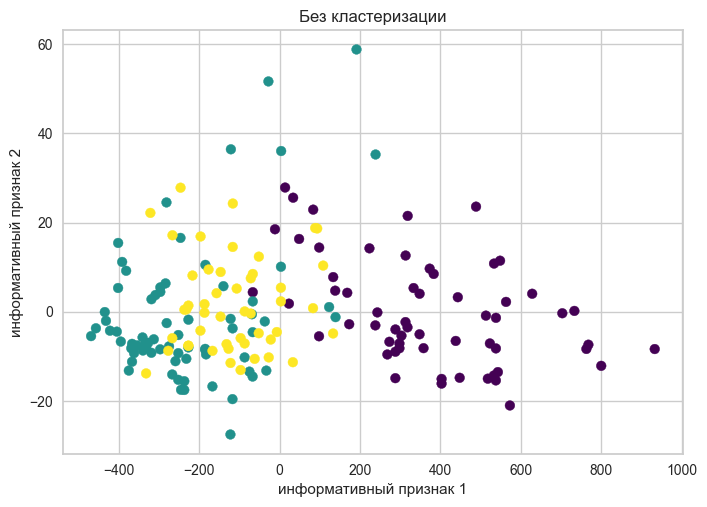

In [46]:
df_wine = load_wine(as_frame=True).frame
x, y = df_wine.drop("target", axis=1), df_wine["target"]

plot_PCA(x, y, "Без кластеризации")

#### KMeans

Разобъем данные на кластеры в изначальном количестве

Adjusted Rand Index            0.371114
Adjusted Mutual Information    0.422687
Homogeneity Score              0.428812
Completeness Score             0.428701
V-Measure Score                0.428757
Silhouette Score               0.571138
Accuracy                       0.168539
Mistake Rate                   0.831461
dtype: float64

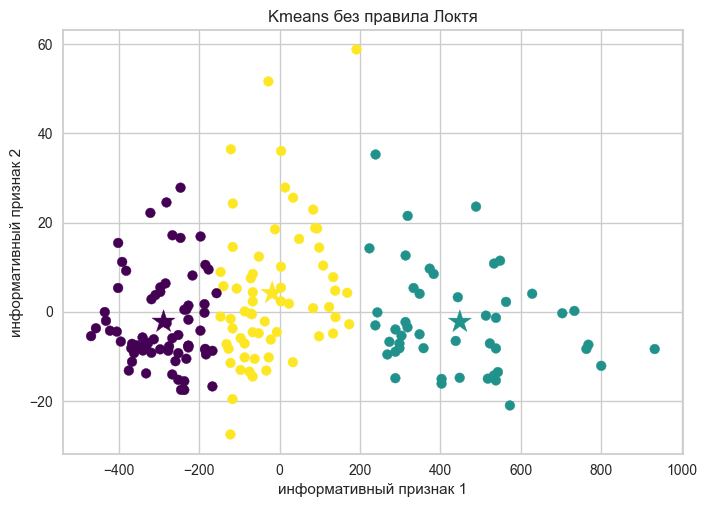

In [47]:
n = np.unique(y if isinstance(y, np.ndarray) else y.values).size
kmeans = KMeans(n_clusters=n, random_state=42)
kmeans.fit(x)
labels = kmeans.predict(x)

display(cl_scores(x, y, kmeans.labels_))
plot_PCA(x, labels, "Kmeans без правила Локтя", kmeans.cluster_centers_)

Используем метод локтя для нахождения оптимального числа кластеров

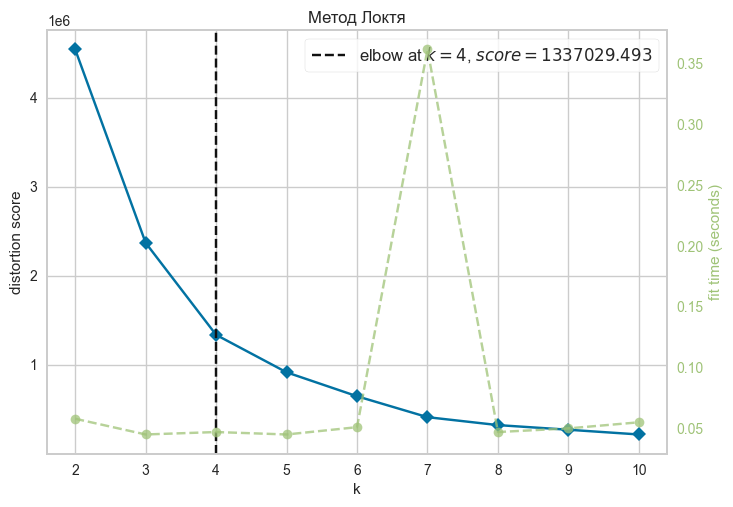

In [48]:
kmeans = KMeans(n_clusters=elbow_val(x), random_state=42)
kmeans.fit(x)
labels = kmeans.predict(x)

Используем полученное число и построим результат

Adjusted Rand Index            0.288788
Adjusted Mutual Information    0.360279
Homogeneity Score              0.409747
Completeness Score             0.336367
V-Measure Score                0.369449
Silhouette Score               0.557229
Accuracy                       0.191011
Mistake Rate                   0.808989
dtype: float64

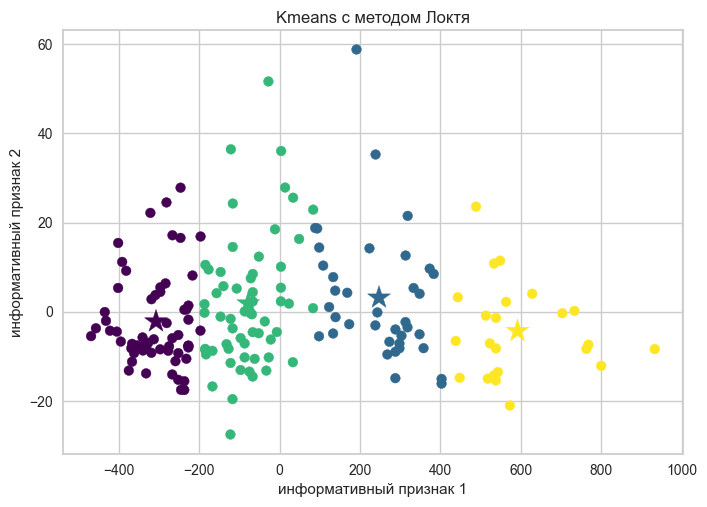

In [49]:
display(cl_scores(x, y, kmeans.labels_))
plot_PCA(x, labels, "Kmeans c методом Локтя", kmeans.cluster_centers_)

#### AffinityPropagation

Adjusted Rand Index            0.222276
Adjusted Mutual Information    0.360149
Homogeneity Score              0.508126
Completeness Score             0.298036
V-Measure Score                0.375706
Silhouette Score               0.545087
Accuracy                       0.185393
Mistake Rate                   0.814607
dtype: float64

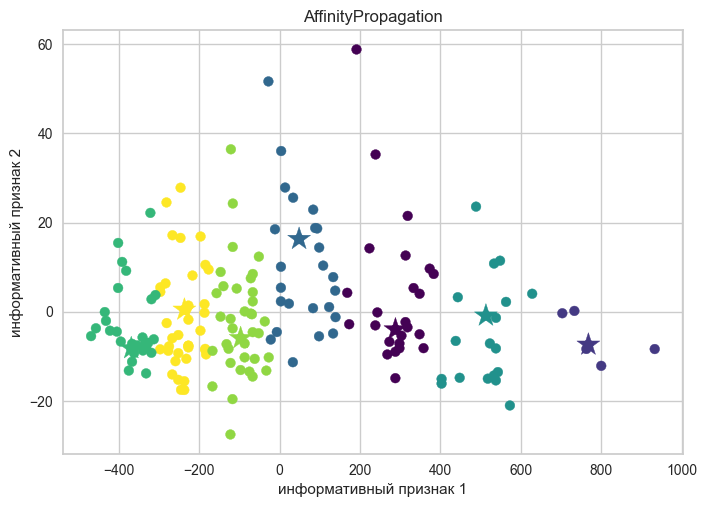

In [51]:
af_grid = {
        'damping': [0.5, 0.6, 0.7, 0.8, 0.9],
        'max_iter': [50, 100, 200, 500],
}

fitted = []
for params in ParameterGrid(af_grid):
    af_prop = AffinityPropagation(**params, random_state=42).fit(x)
    fitted.append((af_prop, silhouette_score(x, af_prop.labels_)))

af_prop = max(fitted, key=lambda model: model[1])[0]
n_clusters = len(af_prop.cluster_centers_indices_)
display(cl_scores(x, y, af_prop.labels_))
plot_PCA(x, af_prop.labels_, "AffinityPropagation", af_prop.cluster_centers_)